<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 10th exercise: <font color="#C70039">Interpretable Machine Learning by means of Shapley Values</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: Finn Heydemann
* Date:   08.08.2023

<img src="https://shap.readthedocs.io/en/latest/_images/example_notebooks_overviews_An_introduction_to_explainable_AI_with_Shapley_values_13_0.png" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:

Before using Shapley values to explain complicated models, it is helpful to understand how they work for simple models.

In this respect the example in this notebook computes a model for the titanic data set (downloaded from Kaggle) and uses its outputs for explanation of feature importance using SHAP deepexplainer. In addition, several different visualization techniques (plots) for Shapley values are going to be demonstrated. 

For a description of the features please refer to <a href="https://www.kaggle.com/competitions/titanic/data">Kaggle Titanic data set</a>.

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. Develop a CNN for image classification and adapt the Shapley Value idea to that model. Comment your entire code.  
---------------------------------

## Imports
Import all necessary python utilities.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import os
%matplotlib inline
import shap
import warnings 
warnings.filterwarnings('ignore')

2023-12-17 18:54:24.257431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## load build-in dataset
take the titanic data set

In [2]:

train_data = pd.read_csv('data/titanic/train.csv', index_col=0)
test_data = pd.read_csv('data/titanic/test.csv', index_col=0)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing
Since the titanic data is a raw data set there is a need to preprocess it by dropping unnecessary columns, handling missing data, converting categorical features to numeric features and conducting one-hot encoding.

In [3]:
def data_preprocessing(df):
    
    df = df.drop(columns=['Name', 'Ticket', 'Cabin'])
    
    # fill na
    df[['Age']] = df[['Age']].fillna(value=df[['Age']].mean())
    df[['Embarked']] = df[['Embarked']].fillna(value=df['Embarked'].value_counts().idxmax())
    df[['Fare']] = df[['Fare']].fillna(value=df[['Fare']].mean())
    
    # encode categorical features into numeric
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
    # one-hot encoding
    embarked_one_hot = pd.get_dummies(df['Embarked'], prefix='Embarked')
    
    df = df.drop('Embarked', axis=1)
    df = df.join(embarked_one_hot)
    
    return df

In [4]:
# training data processing
train_data = data_preprocessing(train_data)
train_data.isnull().sum()

# create data for training
x_train = train_data.drop(['Survived'], axis=1).values

# Check testing data
test_data.isnull().sum()

# normalize training data
scale = StandardScaler()
x_train = scale.fit_transform(x_train)

# prepare y_train
y_train = train_data['Survived'].values

# preprocess testing data
test_data = data_preprocessing(test_data)
x_test = test_data.values.astype(float)

# normalize testing data
x_test = scale.transform(x_test)

# Check testing data
test_data.isnull().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

### Build a simple vanilla ANN, compile and fit the model.

In [5]:
x_train.min()

-2.2531554887793948

In [6]:
model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit model
model.fit(x_train, y_train, epochs=100, batch_size=64)

Epoch 1/100


2023-12-17 18:54:25.286567: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


14/14 [==============================] - 1s 4ms/step - loss: 0.6752 - accuracy: 0.5567
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6237 - accuracy: 0.6420
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5842 - accuracy: 0.7183
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5637 - accuracy: 0.7542
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5593 - accuracy: 0.7306
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5264 - accuracy: 0.7688
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5187 - accuracy: 0.7654
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5085 - accuracy: 0.7744
Epoch 9/100
14/14 [==============================] - 0s 3ms/step - loss: 0.4845 - accuracy: 0.7924
Epoch 10/100
14/14 [==============================] - 0s 2ms/step - loss: 0.4888 - accuracy: 0.7969
Epoch 11/100
14/14 [=

### Now, compute the Shapley values

In [7]:
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test)
shap_values

[array([[ 0.05423852,  0.16233373,  0.02318682, ..., -0.01188713,
          0.09136899, -0.0240086 ],
        [ 0.08069721, -0.14925867,  0.01674546, ..., -0.00640352,
          0.0053753 ,  0.00919172],
        [ 0.01615058,  0.17092327,  0.07174964, ..., -0.01181307,
          0.07219895, -0.01138471],
        ...,
        [ 0.07629597,  0.14646589,  0.0486063 , ..., -0.00848231,
         -0.00962658,  0.01267262],
        [ 0.07843381,  0.13353008, -0.01019708, ..., -0.00594252,
         -0.00379308,  0.01300846],
        [ 0.08700448,  0.10869418,  0.02990497, ...,  0.00152962,
         -0.01709231, -0.08912024]]),
 array([[-0.05423852, -0.16233373, -0.02318682, ...,  0.01188712,
         -0.09136898,  0.0240086 ],
        [-0.0806972 ,  0.14925867, -0.01674545, ...,  0.00640352,
         -0.0053753 , -0.00919172],
        [-0.01615058, -0.17092327, -0.07174964, ...,  0.01181307,
         -0.07219895,  0.01138472],
        ...,
        [-0.07629597, -0.1464659 , -0.04860629, ...,  

### Shapley values interpretation 
#### Global interpretation method

The summary plot shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

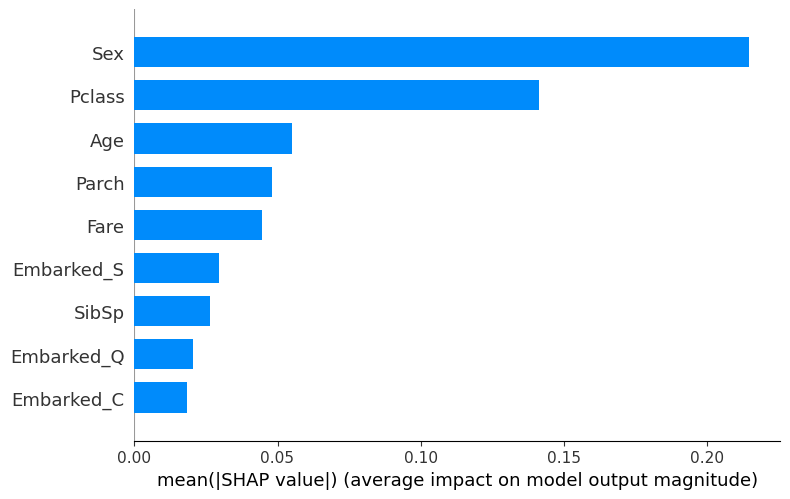

In [8]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = test_data.columns)

#### Local Interpretation methods
##### Force plot
The force plot is great for seeing where the “output value” fits in relation to the “base value”. 
Further, it is possible to observe which features have a positive (red) or negative (blue) impact on the prediction and in addition the magnitude of the impact.

In [9]:
shap.initjs()

1/1 [==============================] - 0s 53ms/step
[[0.02461495 0.97538507]]
Pclass            2
Sex               1
Age            0.92
SibSp             1
Parch             2
Fare          27.75
Embarked_C    False
Embarked_Q    False
Embarked_S     True
Name: 1142, dtype: object


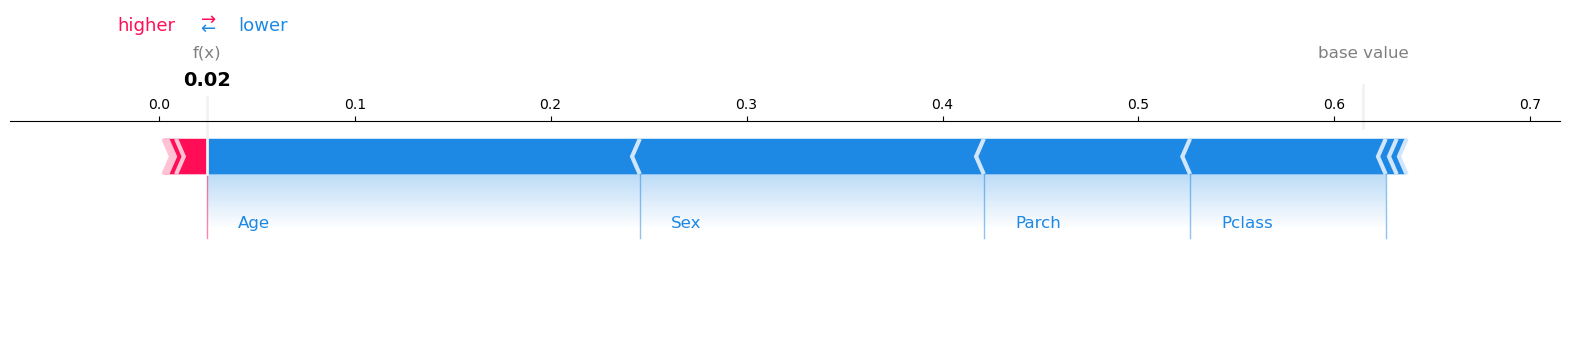

In [10]:
i = 250
print(model.predict(x_test[i:i+1]))
print(test_data.iloc[i])
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][i], features = test_data.columns, matplotlib=True)

##### Decision plot
The decision plot enables to observe the amplitude of each change taken by a sample for the values of the displayed features.

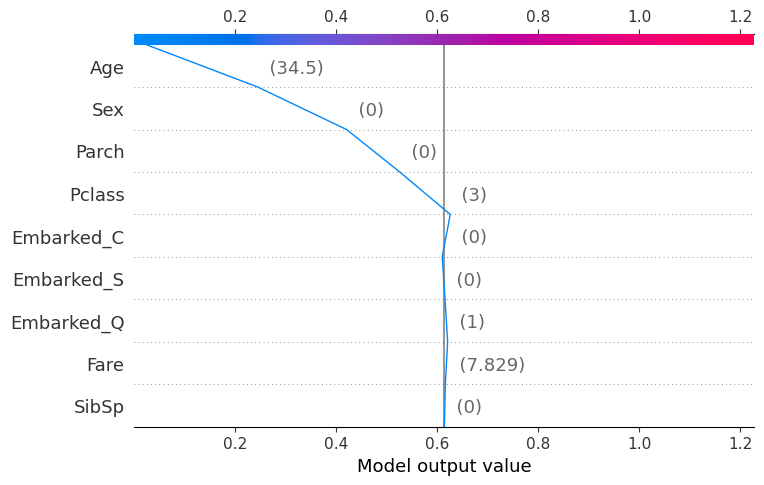

In [11]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][i], features = test_data.iloc[0,:], 
                   feature_names = test_data.columns.tolist())

##### Waterfall plot
The waterfall plot allows for seeing the amplitude and the nature of the impact of a feature. 
It also allows for seeing the order of importance of the features and the values taken by each feature for the sample.

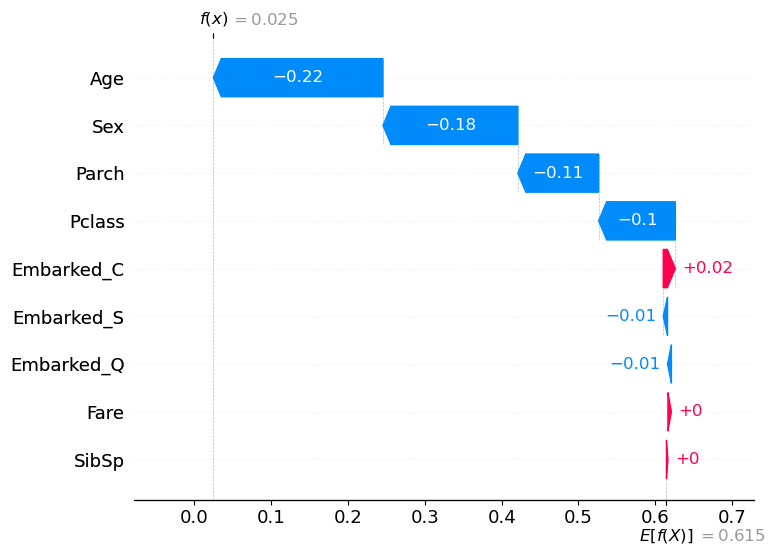

In [12]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][i], 
                                       feature_names = test_data.columns)

## Try to compute shap values on my own


First try to understand the library: Code below is copied and simplyfied 

In [14]:
import tensorflow as tf

def phi_symbolic(i):
    """ Get the SHAP value computation graph for a given model output.
    """
   
    @tf.function
    def grad_graph(shap_rAnD):
        phase = tf.keras.backend.learning_phase()
        tf.keras.backend.set_learning_phase(0)

        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(shap_rAnD)
            out = explainer.model(shap_rAnD)
            if explainer.multi_output:
                out = out[:,i]

        explainer._init_between_tensors(out.op, shap_rAnD)
        x_grad = tape.gradient(out, shap_rAnD)
        tf.keras.backend.set_learning_phase(phase)
        return x_grad

    explainer.phi_symbolics[i] = grad_graph

    return explainer.phi_symbolics[i]
    

def shap_values(X, ranked_outputs=None, output_rank_order="max", check_additivity=True):
    # check if we have multiple inputs
    if isinstance(X, list) and len(X) != 1:
        raise ValueError("Expected a single tensor as model input!")
    elif not isinstance(X, list):
        X = [X]
    assert len(explainer.model_inputs) == len(X), "Number of model inputs (%d) does not match the number given (%d)!" % (len(explainer.model_inputs), len(X))

    # compute the attributions
    output_phis = []
    phis = np.zeros_like(X[0])
    for j in range(X[0].shape[0]):
        bg_data = explainer.data
        
        tiled_X = [np.tile(X[0][j, :], (bg_data[0].shape[0], 1))]
        
        joint_input = [np.concatenate([tiled_X[0], bg_data[0]], 0)]
        
        # run attribution computation graph
        sample_phis = explainer.run(phi_symbolic(0), explainer.model_inputs, joint_input)
        
        # assign the attributions to the right part of the output arrays
        phis[j] = (sample_phis[0][bg_data[0].shape[0]:] * (X[0][j] - bg_data[0])).mean(0)
        
    return phis
    
    
explainer = shap.DeepExplainer(model, x_train).explainer
shap_val = shap_values(x_test)

In [15]:
np.abs(shap_val).mean(axis=0)

array([0.14129085, 0.21470557, 0.05518179, 0.02627479, 0.04811384,
       0.04451882, 0.01838769, 0.02057474, 0.02948183])

In [117]:
# https://christophm.github.io/interpretable-ml-book/shapley.html
def get_permutations(x, z, feat_idx):
    assert x.shape == z.shape
    l = list(range(x.shape[1]))
    l.remove(feat_idx)
    ll = np.random.permutation(l)
    ll = np.insert(ll, feat_idx, feat_idx)
    x_pls_j = np.append(x[:, ll[:feat_idx+1]], z[:, ll[feat_idx+1:]], axis=1)
    x_mns_j = np.append(x[:, ll[:feat_idx]], z[:, ll[feat_idx:]], axis=1)
    return x_pls_j, x_mns_j
    
get_permutations(np.array([[5, 6, 7, 8]]), np.array([[1, 2, 3, 4]]), 1)

(array([[5, 6, 4, 3]]), array([[5, 2, 4, 3]]))

In [186]:
def compute_shap_values(feat_idx):
    x = x_train[np.random.choice(x_train.shape[0], 500, replace=False), :] # randomly choose rows from x_train 
    z = np.tile(x_test[0], (500, 1)) # choose songle sample from x_test
    x_plus_j, x_minus_j = get_permutations(x, z, feat_idx)
    diff = model.predict(x_plus_j) - model.predict(x_minus_j)
    return np.mean(diff, axis=0)
    
compute_shap_values(0)

16/16 [==============================] - 0s 2ms/step


array([-0.03168424,  0.03168413], dtype=float32)

In [233]:
svs = []
for _ in range(10): 
    svs.append(compute_shap_values(1))

16/16 [==============================] - 0s 2ms/step


In [234]:
np.mean(np.vstack(svs), axis=0)

array([-0.15415852,  0.15415852], dtype=float32)

In [185]:
# These are the shaply values computed by library 
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test[0:1])
shap_values

[array([[ 0.05423852,  0.16233373,  0.02318682, -0.00345705, -0.0208473 ,
          0.03038135, -0.01188713,  0.09136899, -0.0240086 ]]),
 array([[-0.05423852, -0.16233373, -0.02318682,  0.00345705,  0.0208473 ,
         -0.03038135,  0.01188712, -0.09136898,  0.0240086 ]])]

## Result

Self computed shaply values pretty close to the ones computes with the shap library
Library gets to 0.16 for the second feature, my computation is at 0.15 

Trying to understand what happens inside the library is though very hard to understand 

## Image Classification with shapley as explainer


In [235]:
# read the data

train_df = pd.read_csv("data/fashion-mnist_train.csv")
x_train = train_df.values[:, :-1]
y_train = train_df.values[:, 0]
x_train.shape, y_train.shape

((60000, 784), (60000,))

In [236]:
# reshape into image format 
x_train = x_train.reshape(-1,  28, 28, 1) / 255
x_train.shape

(60000, 28, 28, 1)

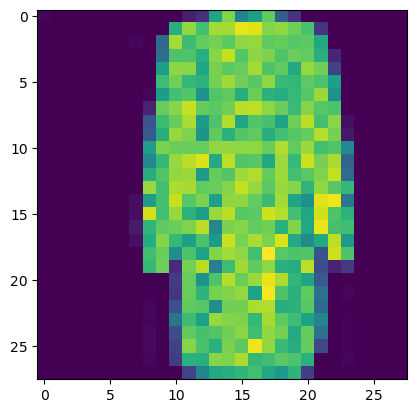

In [237]:
plt.imshow(x_train[200,  :, :, 0])

In [238]:
# read and prepare test and validation data 

xtest_data = pd.read_csv("data/fashion-mnist_test.csv").values[:, :-1].reshape(-1, 28, 28, 1)
ytest_data = pd.read_csv("data/fashion-mnist_test.csv").values[:, 0]

x_test = xtest_data[:5000] / 255
x_val = xtest_data[5000:] / 255
y_test = ytest_data[:5000] 
y_val = ytest_data[5000:]
y_val, y_test

(array([1, 2, 4, ..., 8, 8, 1]), array([0, 1, 2, ..., 2, 6, 9]))

In [239]:
# One hot encoding 

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]
y_val = np.eye(10)[y_val]

In [240]:
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dropout
from keras.optimizers import Adam

model = Sequential()

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [241]:
history = model.fit(x_train, y_train, batch_size=128, epochs=12, validation_data=(x_val, y_val))

Epoch 1/12
469/469 [==============================] - 73s 155ms/step - loss: 0.5354 - accuracy: 0.8078 - val_loss: 0.3147 - val_accuracy: 0.8924
Epoch 2/12
469/469 [==============================] - 82s 175ms/step - loss: 0.3495 - accuracy: 0.8746 - val_loss: 0.2651 - val_accuracy: 0.9082
Epoch 3/12
469/469 [==============================] - 78s 166ms/step - loss: 0.3018 - accuracy: 0.8918 - val_loss: 0.2476 - val_accuracy: 0.9114
Epoch 4/12
469/469 [==============================] - 77s 164ms/step - loss: 0.2709 - accuracy: 0.9025 - val_loss: 0.2348 - val_accuracy: 0.9148
Epoch 5/12
469/469 [==============================] - 77s 165ms/step - loss: 0.2485 - accuracy: 0.9099 - val_loss: 0.2180 - val_accuracy: 0.9210
Epoch 6/12
469/469 [==============================] - 77s 164ms/step - loss: 0.2276 - accuracy: 0.9173 - val_loss: 0.2242 - val_accuracy: 0.9198
Epoch 7/12
469/469 [==============================] - 77s 165ms/step - loss: 0.2077 - accuracy: 0.9230 - val_loss: 0.2054 - val_ac

In [242]:
# test data is more or less balanced --> I'm going to got with accuracy as model measure instead of f1 
np.sum(y_test, axis=0)

array([502., 490., 490., 507., 506., 490., 519., 471., 508., 517.])

In [243]:
# predict and transform back to numeric values 
performance = np.argmax(model.predict(x_test), axis=1) == np.argmax(y_test, axis=1)

157/157 [==============================] - 6s 37ms/step


In [244]:
np.count_nonzero(performance) / len(performance)

0.9326

In [245]:
samples = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

In [246]:
import shap

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

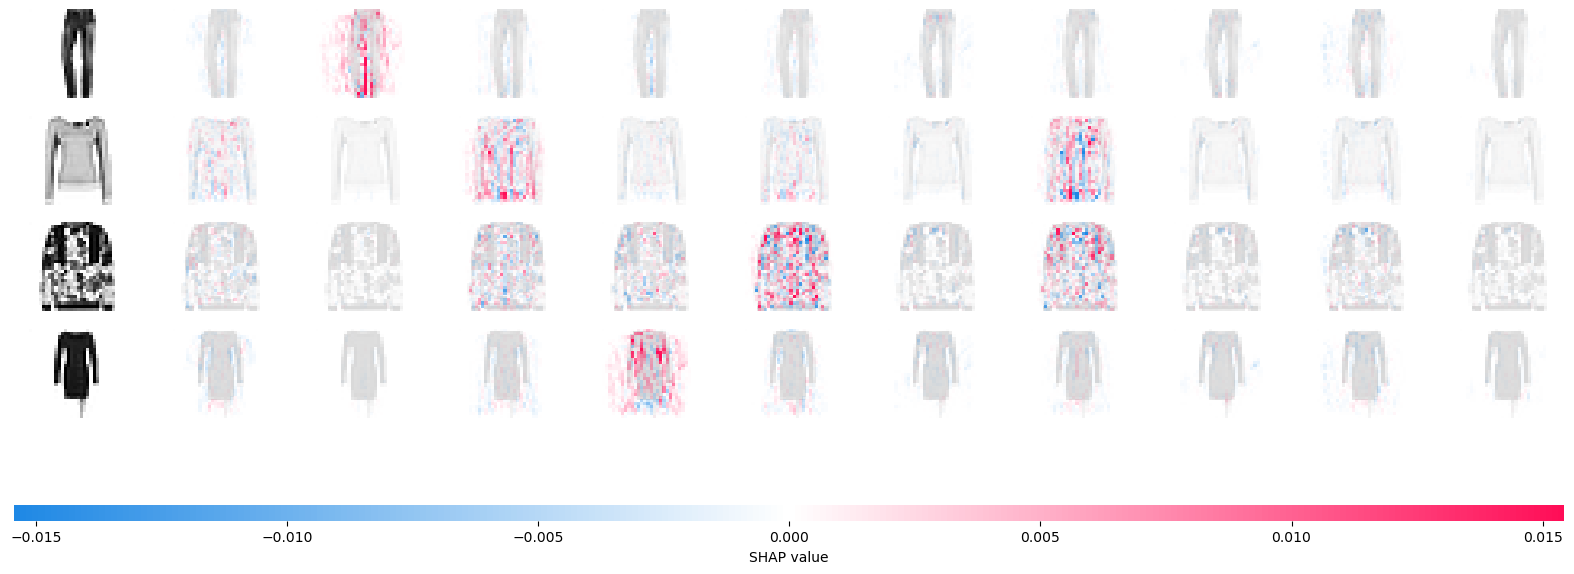

In [247]:
shap.image_plot(shap_values, -x_test[1:5])